In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import matplotlib.pyplot as plt

In [0]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
# The tfds package is the easiest way to load pre-defined data.
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [0]:
# Using the subsplit feature to divide it into 
# (train, validation, test) with 80%, 10%, and 10% of the data respectively.
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', "train[80%:90%]", "train[90%:]"],
    with_info=True,
    as_supervised=True
)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteVNYAMB/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [0]:
print(raw_train)
print(raw_validation)
print(raw_test)

<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


dog
dog


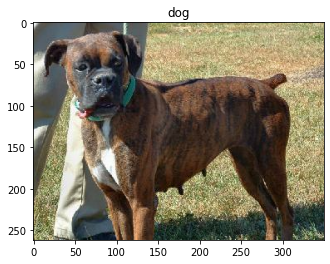

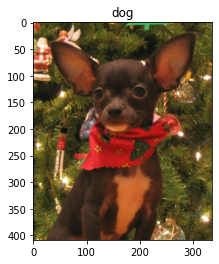

In [0]:
# Showing the first two images and labels from the training set
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
    plt.figure()
    plt.imshow(image)
    print(get_label_name(label))
    plt.title(get_label_name(label))

In [0]:
# Format images for the task
# Resize the images to a fixed input size and rescale the input channels to a range[-1,1]
IMG_SIZE = 160  # All images will be resized to 160 x 160

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [0]:
# Applying this to each item in the dataset using map method
train = raw_train.map(format_example)
validaiton = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [0]:
# Shuffle and batch the data
SHUFFLE_BUFFER_SIZE = 1000
BATCH_SIZE = 32

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validaiton.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [0]:
# Inspect a batch of data
for image_batch, label_batch in train_batches.take(1):
    pass
image_batch.shape

TensorShape([32, 160, 160, 3])

In [0]:
# We use the very last layer before the flatten operation for feature extraction. 
# This layer is called the "bottleneck layer". 
# The bottleneck layer features retain more generality as compared to the final/top layer.
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)  # 3 is no. of channels

# Create a base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, 
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [0]:
# The fature extractor converts each 160 x 160 x 3 image
# into a 5 x 5 x 1280 block of features
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature Extraction - 
In this step, we freeze the convolutional base created from the previous step and to use as a feature extractor. We add a classifier on top of it and train the top-level classifier

## Freeze the convolutional base
* Freezing the convolutional base before compiling and training the model is important.
* Freezing prevents the weigths in a given layer from being updated during training. 

In [0]:
# Freezing the convolutional base
base_model.trainable = False

In [0]:
# For the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

## Adding a classification Head

* To generate predictions from the block of features, average over the spatial 5 x 5 spatial locations, using ``tf.keras.layers.GlobalAveragePooling2D`` layer to convert the features to a single 1280 element vector per image

In [0]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


* Applying ``tf.keras.layers.Dense`` layer to convert these features into a single prediction per image.
* We don't need an activation function here since this prediction will be treated as a ``logit`` or a raw prediction value.
* positive numbers predict class 1 and negative numbers predict class 0

In [0]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Stack the feature extractor, and these two layers using ``tf.keras.Sequential`` model

In [0]:
model = tf.keras.Sequential([
                             base_model,
                             global_average_layer,
                             prediction_layer])

## Compile the model
* You must compile the model before training it.
* Since there are two classes, use binary_crossentropy with ``from_logits==True`` since the model provides a linear output

In [0]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


* Here 2.5 M parameter in MobileNet are frozen but 1.2k parameter are trainable parameters in the Dense layer. 

In [0]:
len(model.trainable_variables)

2

## Train the model

In [0]:
# Initial Loss and Accuracy of the model on validation_batches before training it
initial_epochs = 10
validation_steps = 20
loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

20/20 [==============================] - 1s 59ms/step - loss: 0.6273 - accuracy: 0.5359


In [0]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.63
initial accuracy: 0.54


In [0]:
# Fitting the model to the train set
history = model.fit(train_batches, 
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 59s 102ms/step - loss: 0.3430 - accuracy: 0.8352 - val_loss: 0.2029 - val_accuracy: 0.8758
Epoch 2/10
582/582 [==============================] - 57s 98ms/step - loss: 0.1938 - accuracy: 0.9193 - val_loss: 0.1546 - val_accuracy: 0.9050
Epoch 3/10
582/582 [==============================] - 57s 98ms/step - loss: 0.1650 - accuracy: 0.9321 - val_loss: 0.1383 - val_accuracy: 0.9222
Epoch 4/10
582/582 [==============================] - 58s 99ms/step - loss: 0.1503 - accuracy: 0.9376 - val_loss: 0.1217 - val_accuracy: 0.9347
Epoch 5/10
582/582 [==============================] - 57s 98ms/step - loss: 0.1357 - accuracy: 0.9440 - val_loss: 0.1180 - val_accuracy: 0.9390
Epoch 6/10
582/582 [==============================] - 57s 98ms/step - loss: 0.1318 - accuracy: 0.9461 - val_loss: 0.1137 - val_accuracy: 0.9437
Epoch 7/10
582/582 [==============================] - 57s 98ms/step - loss: 0.1287 - accuracy: 0.9455 - val_loss: 0.1048 - val_accuracy

## Learning Curves

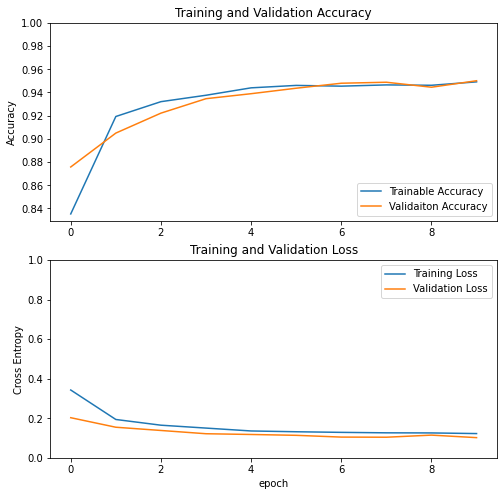

In [0]:
# Plotting Training Accuracy vs Validation Accurcy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc, label='Trainable Accuracy')
plt.plot(val_acc, label='Validaiton Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

# Plotting Training loss vs Validation loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

* Here the validation metrics are better than training metrics, because layers like ``tf.keras.layers.BatchNormalization`` and ``tf.keras.layers.Dropout`` affect accuracy during training.
* They are turned off while calculating validation loss.
* Also, training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

In [0]:
# Saving the file in colab
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!ls /content/gdrive/My\ Drive/transfer_learning

In [0]:
path = F"/content/gdrive/My Drive/transfer_learning/model_mobileNetV2_9510.h5" 
model.save(path)

In [0]:
# Evaluating the model on test set
model.evaluate(test_batches)

73/73 [==============================] - 5s 63ms/step - loss: 0.1049 - accuracy: 0.9510


[0.10488025844097137, 0.9509888291358948]